In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import math
import requests
from bs4 import BeautifulSoup
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
pd.set_option("display.max_columns",100)

In [5]:
## Proxy settings when using cntlm
http_proxy  = "http://localhost:3128"
https_proxy = "https://localhost:3128"

proxyDict = { 
              "http"  : http_proxy, 
              "https" : https_proxy, 
            }
proxyDict = None

In [6]:
mapping = {
    'Richmond': 'richmond',
    'West Coast': 'westcoast',
    'Sydney': 'swans',
    'Adelaide': 'adelaide',
    'Geelong': 'geelong',
    'Greater Western Sydney': 'gws',
    'Melbourne': 'melbourne',
    'Port Adelaide': 'padelaide',
    'Collingwood': 'collingwood',
    'Hawthorn': 'hawthorn',
    'Essendon': 'essendon',
    'Western Bulldogs': 'bullldogs',
    'St Kilda': 'stkilda',
    'North Melbourne': 'kangaroos',
    'Kangaroos' : 'kangaroos',
    'Fremantle': 'fremantle',
    'Brisbane Lions': 'brisbanel',
    'Gold Coast': 'goldcoast',
    'Carlton': 'carlton'
}

In [7]:
from data_prep.team_history import History
team_df = History(mapping, proxyDict).generate_team_history()

Richmond 1


/Users/d719674/dev/code/AFL-Monash-comp/data_prep/web_scraping.py:16: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 16 of the file /Users/d719674/dev/code/AFL-Monash-comp/data_prep/web_scraping.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(r.text, "html")


Richmond 2
Richmond 3
Richmond 4
Richmond 5
Richmond 6
Richmond 7
Richmond 8
Richmond 9
Richmond 10
Richmond 11
Richmond 12
Richmond 13
Richmond 14
Richmond 15
West Coast 1
West Coast 2
West Coast 3
West Coast 4
West Coast 5
West Coast 6
West Coast 7
West Coast 8
West Coast 9
West Coast 10
West Coast 11
West Coast 12
West Coast 13
West Coast 14
West Coast 15
Sydney 1
Sydney 2
Sydney 3
Sydney 4
Sydney 5
Sydney 6
Sydney 7
Sydney 8
Sydney 9
Sydney 10
Sydney 11
Sydney 12
Sydney 13
Sydney 14
Sydney 15
Adelaide 1
Adelaide 2
Adelaide 3
Adelaide 4
Adelaide 5
Adelaide 6
Adelaide 7
Adelaide 8
Adelaide 9
Adelaide 10
Adelaide 11
Adelaide 12
Adelaide 13
Adelaide 14
Adelaide 15
Geelong 1
Geelong 2
Geelong 3
Geelong 4
Geelong 5
Geelong 6
Geelong 7
Geelong 8
Geelong 9
Geelong 10
Geelong 11
Geelong 12
Geelong 13
Geelong 14
Geelong 15
Greater Western Sydney 1
Greater Western Sydney 2
Greater Western Sydney 3
Greater Western Sydney 4
Greater Western Sydney 5
Greater Western Sydney 6
Greater Western Sydne

In [31]:
History(mapping, proxyDict).generate_game_data('training-all/', team_df)
History(mapping, proxyDict).generate_game_data_ha('training-hva/', team_df)

2018
Richmond Carlton
Richmond Hawthorn
Richmond Brisbane Lions
Richmond Fremantle
Richmond St Kilda
Richmond Sydney
Richmond Adelaide
Richmond Collingwood
Richmond Geelong
Richmond Essendon
Richmond Western Bulldogs
West Coast Sydney
West Coast Geelong
West Coast Gold Coast
West Coast Port Adelaide
West Coast Richmond
West Coast St Kilda
West Coast Essendon
West Coast Greater Western Sydney
West Coast Western Bulldogs
West Coast Fremantle
West Coast Melbourne
Sydney Port Adelaide
Sydney Greater Western Sydney
Sydney Adelaide
Sydney North Melbourne
Sydney Fremantle
Sydney Carlton
Sydney West Coast
Sydney Geelong
Sydney Gold Coast
Sydney Collingwood
Sydney Hawthorn
Adelaide Richmond
Adelaide Collingwood
Adelaide Gold Coast
Adelaide Carlton
Adelaide Western Bulldogs
Adelaide Greater Western Sydney
Adelaide West Coast
Adelaide Geelong
Adelaide Melbourne
Adelaide Port Adelaide
Adelaide North Melbourne
Geelong Hawthorn
Geelong St Kilda
Geelong Sydney
Geelong Greater Western Sydney
Geelong C

Fremantle Richmond
Brisbane Lions Essendon
Brisbane Lions Richmond
Brisbane Lions Port Adelaide
Brisbane Lions Adelaide
Brisbane Lions Fremantle
Brisbane Lions Greater Western Sydney
Brisbane Lions Geelong
Brisbane Lions Carlton
Brisbane Lions Western Bulldogs
Brisbane Lions Gold Coast
Brisbane Lions North Melbourne
Gold Coast Brisbane Lions
Gold Coast Hawthorn
Gold Coast Adelaide
Gold Coast Geelong
Gold Coast Port Adelaide
Gold Coast West Coast
Gold Coast Carlton
Gold Coast North Melbourne
Gold Coast Collingwood
Gold Coast Richmond
Gold Coast Essendon
Carlton Richmond
Carlton Essendon
Carlton Gold Coast
Carlton Sydney
Carlton North Melbourne
Carlton Greater Western Sydney
Carlton Adelaide
Carlton Melbourne
Carlton Western Bulldogs
Carlton Geelong
Carlton Hawthorn
2016
Richmond Carlton
Richmond Adelaide
Richmond Port Adelaide
Richmond Hawthorn
Richmond Sydney
Richmond Gold Coast
Richmond Brisbane Lions
Richmond Essendon
Richmond Collingwood
Richmond Geelong
Richmond St Kilda
West Coast

St Kilda Richmond
St Kilda Fremantle
St Kilda Geelong
St Kilda Sydney
North Melbourne Brisbane Lions
North Melbourne Port Adelaide
North Melbourne Hawthorn
North Melbourne Richmond
North Melbourne West Coast
North Melbourne Sydney
North Melbourne Geelong
North Melbourne Essendon
North Melbourne St Kilda
North Melbourne Fremantle
North Melbourne Western Bulldogs
Fremantle Port Adelaide
Fremantle Sydney
Fremantle Essendon
Fremantle North Melbourne
Fremantle Richmond
Fremantle Collingwood
Fremantle Brisbane Lions
Fremantle Carlton
Fremantle Greater Western Sydney
Fremantle West Coast
Fremantle Melbourne
Brisbane Lions Collingwood
Brisbane Lions Richmond
Brisbane Lions West Coast
Brisbane Lions Port Adelaide
Brisbane Lions St Kilda
Brisbane Lions Adelaide
Brisbane Lions Sydney
Brisbane Lions North Melbourne
Brisbane Lions Gold Coast
Brisbane Lions Carlton
Brisbane Lions Western Bulldogs
Gold Coast St Kilda
Gold Coast Brisbane Lions
Gold Coast Adelaide
Gold Coast Collingwood
Gold Coast Sydn

Hawthorn Richmond
Hawthorn Collingwood
Essendon Melbourne
Essendon Collingwood
Essendon Greater Western Sydney
Essendon Brisbane Lions
Essendon Carlton
Essendon Gold Coast
Essendon Port Adelaide
Essendon Hawthorn
Essendon West Coast
Essendon North Melbourne
Essendon Richmond
Western Bulldogs Brisbane Lions
Western Bulldogs Fremantle
Western Bulldogs Geelong
Western Bulldogs North Melbourne
Western Bulldogs Port Adelaide
Western Bulldogs Richmond
Western Bulldogs Essendon
Western Bulldogs West Coast
Western Bulldogs Sydney
Western Bulldogs Adelaide
Western Bulldogs Melbourne
St Kilda Richmond
St Kilda Essendon
St Kilda Sydney
St Kilda Carlton
St Kilda Western Bulldogs
St Kilda West Coast
St Kilda Melbourne
St Kilda Port Adelaide
St Kilda Hawthorn
St Kilda Gold Coast
St Kilda Fremantle
North Melbourne Collingwood
North Melbourne Sydney
North Melbourne Brisbane Lions
North Melbourne Port Adelaide
North Melbourne Adelaide
North Melbourne St Kilda
North Melbourne Greater Western Sydney
Nort

Collingwood Western Bulldogs
Collingwood Adelaide
Collingwood West Coast
Collingwood St Kilda
Collingwood Hawthorn
Collingwood North Melbourne
Collingwood Essendon
Collingwood Brisbane Lions
Collingwood Geelong
Hawthorn Melbourne
Hawthorn West Coast
Hawthorn Geelong
Hawthorn St Kilda
Hawthorn Fremantle
Hawthorn Gold Coast
Hawthorn Essendon
Hawthorn Brisbane Lions
Hawthorn North Melbourne
Hawthorn Port Adelaide
Hawthorn Western Bulldogs
Essendon Western Bulldogs
Essendon Collingwood
Essendon Gold Coast
Essendon West Coast
Essendon Melbourne
Essendon North Melbourne
Essendon Geelong
Essendon Richmond
Essendon Carlton
Essendon Sydney
Essendon Port Adelaide
Western Bulldogs Brisbane Lions
Western Bulldogs Gold Coast
Western Bulldogs Sydney
Western Bulldogs Richmond
Western Bulldogs Hawthorn
Western Bulldogs Adelaide
Western Bulldogs Melbourne
Western Bulldogs Carlton
Western Bulldogs West Coast
Western Bulldogs Essendon
Western Bulldogs Fremantle
St Kilda Richmond
St Kilda Essendon
St Kild

Hawthorn St Kilda
Hawthorn Adelaide
Hawthorn Essendon
Essendon Fremantle
Essendon Collingwood
Essendon Hawthorn
Essendon Geelong
Essendon Adelaide
Essendon Melbourne
Essendon Carlton
Essendon Western Bulldogs
Essendon Richmond
Essendon Brisbane Lions
Essendon St Kilda
Western Bulldogs North Melbourne
Western Bulldogs Richmond
Western Bulldogs Carlton
Western Bulldogs St Kilda
Western Bulldogs Sydney
Western Bulldogs Port Adelaide
Western Bulldogs Hawthorn
Western Bulldogs Collingwood
Western Bulldogs Fremantle
Western Bulldogs West Coast
Western Bulldogs Geelong
St Kilda Sydney
St Kilda West Coast
St Kilda Fremantle
St Kilda Essendon
St Kilda Brisbane Lions
St Kilda Melbourne
St Kilda Richmond
St Kilda Geelong
St Kilda Adelaide
St Kilda Western Bulldogs
St Kilda North Melbourne
North Melbourne Hawthorn
North Melbourne Essendon
North Melbourne Richmond
North Melbourne Collingwood
North Melbourne Port Adelaide
North Melbourne Fremantle
North Melbourne Brisbane Lions
North Melbourne St Ki

St Kilda Adelaide
St Kilda Hawthorn
St Kilda Fremantle
St Kilda West Coast
North Melbourne Collingwood
North Melbourne Hawthorn
North Melbourne Brisbane Lions
North Melbourne Sydney
North Melbourne Essendon
North Melbourne Carlton
North Melbourne Adelaide
North Melbourne Western Bulldogs
North Melbourne Melbourne
North Melbourne West Coast
North Melbourne Geelong
Fremantle Port Adelaide
Fremantle West Coast
Fremantle Adelaide
Fremantle Hawthorn
Fremantle St Kilda
Fremantle Richmond
Fremantle Carlton
Fremantle North Melbourne
Fremantle Geelong
Fremantle Essendon
Fremantle Melbourne
Brisbane Lions Hawthorn
Brisbane Lions St Kilda
Brisbane Lions Fremantle
Brisbane Lions Adelaide
Brisbane Lions Collingwood
Brisbane Lions Western Bulldogs
Brisbane Lions Port Adelaide
Brisbane Lions Carlton
Brisbane Lions North Melbourne
Brisbane Lions Sydney
Brisbane Lions Geelong
Carlton Richmond
Carlton Essendon
Carlton Brisbane Lions
Carlton Adelaide
Carlton Western Bulldogs
Carlton Port Adelaide
Carlton

Brisbane Lions Collingwood
Brisbane Lions Essendon
Brisbane Lions Hawthorn
Brisbane Lions Port Adelaide
Carlton Essendon
Carlton Collingwood
Carlton Hawthorn
Carlton Geelong
Carlton Melbourne
Carlton Sydney
Carlton Brisbane Lions
Carlton Fremantle
Carlton Richmond
Carlton Port Adelaide
Carlton North Melbourne
2004
Richmond Collingwood
Richmond Adelaide
Richmond Hawthorn
Richmond Western Bulldogs
Richmond Fremantle
Richmond Carlton
Richmond Essendon
Richmond St Kilda
Richmond Melbourne
Richmond Geelong
Richmond Sydney
West Coast Port Adelaide
West Coast Brisbane Lions
West Coast Fremantle
West Coast Sydney
West Coast Richmond
West Coast Adelaide
West Coast Geelong
West Coast Essendon
West Coast Western Bulldogs
West Coast Carlton
West Coast Melbourne
Sydney Fremantle
Sydney Geelong
Sydney Melbourne
Sydney Richmond
Sydney Hawthorn
Sydney St Kilda
Sydney Collingwood
Sydney Adelaide
Sydney Brisbane Lions
Sydney North Melbourne
Sydney Essendon
Adelaide Brisbane Lions
Adelaide St Kilda
Adela

Gold Coast Brisbane Lions
Carlton Gold Coast
Carlton Collingwood
Carlton West Coast
Carlton Essendon
Carlton Melbourne
Carlton Fremantle
Carlton Port Adelaide
Carlton Hawthorn
Carlton Greater Western Sydney
Carlton Western Bulldogs
Carlton Adelaide
2017
Richmond Collingwood
Richmond West Coast
Richmond Melbourne
Richmond Fremantle
Richmond Essendon
Richmond Sydney
Richmond Carlton
Richmond Brisbane Lions
Richmond Greater Western Sydney
Richmond Hawthorn
Richmond St Kilda
West Coast St Kilda
West Coast Sydney
West Coast Fremantle
West Coast Western Bulldogs
West Coast Greater Western Sydney
West Coast Geelong
West Coast Melbourne
West Coast Port Adelaide
West Coast Brisbane Lions
West Coast Carlton
West Coast Adelaide
Sydney Port Adelaide
Sydney Collingwood
Sydney Greater Western Sydney
Sydney Brisbane Lions
Sydney Hawthorn
Sydney Western Bulldogs
Sydney Essendon
Sydney Gold Coast
Sydney St Kilda
Sydney Fremantle
Sydney Carlton
Adelaide Greater Western Sydney
Adelaide Essendon
Adelaide 

Fremantle Gold Coast
Fremantle Carlton
Fremantle Greater Western Sydney
Fremantle Richmond
Fremantle Essendon
Fremantle Port Adelaide
Fremantle Geelong
Fremantle Sydney
Fremantle West Coast
Fremantle Adelaide
Fremantle Western Bulldogs
Brisbane Lions North Melbourne
Brisbane Lions Gold Coast
Brisbane Lions Sydney
Brisbane Lions Collingwood
Brisbane Lions Hawthorn
Brisbane Lions Fremantle
Brisbane Lions West Coast
Brisbane Lions Greater Western Sydney
Brisbane Lions Port Adelaide
Brisbane Lions Carlton
Brisbane Lions Geelong
Gold Coast Essendon
Gold Coast Carlton
Gold Coast North Melbourne
Gold Coast Melbourne
Gold Coast Adelaide
Gold Coast Sydney
Gold Coast St Kilda
Gold Coast Brisbane Lions
Gold Coast Fremantle
Gold Coast Greater Western Sydney
Gold Coast Port Adelaide
Carlton Sydney
Carlton Western Bulldogs
Carlton Essendon
Carlton Port Adelaide
Carlton Geelong
Carlton Brisbane Lions
Carlton Collingwood
Carlton Adelaide
Carlton West Coast
Carlton St Kilda
Carlton Melbourne
2015
Richm

Western Bulldogs North Melbourne
Western Bulldogs Richmond
Western Bulldogs Carlton
Western Bulldogs Adelaide
Western Bulldogs Fremantle
Western Bulldogs Brisbane Lions
Western Bulldogs Melbourne
Western Bulldogs Gold Coast
Western Bulldogs Essendon
Western Bulldogs Sydney
Western Bulldogs Greater Western Sydney
St Kilda Melbourne
St Kilda Greater Western Sydney
St Kilda Adelaide
St Kilda Brisbane Lions
St Kilda Carlton
St Kilda Gold Coast
St Kilda Collingwood
St Kilda West Coast
St Kilda Richmond
St Kilda Fremantle
St Kilda Western Bulldogs
North Melbourne Essendon
North Melbourne Port Adelaide
North Melbourne Gold Coast
North Melbourne Brisbane Lions
North Melbourne Richmond
North Melbourne Hawthorn
North Melbourne St Kilda
North Melbourne Geelong
North Melbourne Western Bulldogs
North Melbourne Adelaide
North Melbourne Melbourne
Fremantle Gold Coast
Fremantle Essendon
Fremantle North Melbourne
Fremantle Geelong
Fremantle Adelaide
Fremantle Brisbane Lions
Fremantle West Coast
Fremant

Collingwood Geelong
Collingwood Gold Coast
Collingwood West Coast
Collingwood Fremantle
Collingwood Carlton
Collingwood Hawthorn
Collingwood St Kilda
Collingwood North Melbourne
Hawthorn Collingwood
Hawthorn Adelaide
Hawthorn Sydney
Hawthorn Fremantle
Hawthorn North Melbourne
Hawthorn Brisbane Lions
Hawthorn Greater Western Sydney
Hawthorn Geelong
Hawthorn Port Adelaide
Hawthorn Gold Coast
Hawthorn West Coast
Essendon Port Adelaide
Essendon Brisbane Lions
Essendon West Coast
Essendon Richmond
Essendon Melbourne
Essendon Sydney
Essendon Western Bulldogs
Essendon Hawthorn
Essendon North Melbourne
Essendon Carlton
Essendon Collingwood
Western Bulldogs West Coast
Western Bulldogs St Kilda
Western Bulldogs Collingwood
Western Bulldogs Gold Coast
Western Bulldogs Geelong
Western Bulldogs Port Adelaide
Western Bulldogs Brisbane Lions
Western Bulldogs Hawthorn
Western Bulldogs Carlton
Western Bulldogs North Melbourne
Western Bulldogs Sydney
St Kilda Gold Coast
St Kilda Fremantle
St Kilda Hawth

Collingwood Geelong
Collingwood Western Bulldogs
Collingwood West Coast
Collingwood St Kilda
Collingwood Richmond
Collingwood Carlton
Collingwood Adelaide
Hawthorn Geelong
Hawthorn North Melbourne
Hawthorn Sydney
Hawthorn Port Adelaide
Hawthorn Adelaide
Hawthorn Essendon
Hawthorn Western Bulldogs
Hawthorn Brisbane Lions
Hawthorn Melbourne
Hawthorn Fremantle
Hawthorn Collingwood
Essendon Fremantle
Essendon Hawthorn
Essendon Port Adelaide
Essendon Richmond
Essendon Western Bulldogs
Essendon Geelong
Essendon West Coast
Essendon St Kilda
Essendon Carlton
Essendon Collingwood
Essendon Brisbane Lions
Western Bulldogs Collingwood
Western Bulldogs Hawthorn
Western Bulldogs Adelaide
Western Bulldogs St Kilda
Western Bulldogs Sydney
Western Bulldogs Brisbane Lions
Western Bulldogs Port Adelaide
Western Bulldogs Fremantle
Western Bulldogs North Melbourne
Western Bulldogs Geelong
Western Bulldogs Essendon
St Kilda North Melbourne
St Kilda Collingwood
St Kilda Fremantle
St Kilda Carlton
St Kilda Es

Western Bulldogs North Melbourne
Western Bulldogs Brisbane Lions
Western Bulldogs Port Adelaide
Western Bulldogs Melbourne
Western Bulldogs Carlton
Western Bulldogs Sydney
Western Bulldogs Essendon
St Kilda Sydney
St Kilda Carlton
St Kilda Geelong
St Kilda Essendon
St Kilda Collingwood
St Kilda Melbourne
St Kilda Western Bulldogs
St Kilda Fremantle
St Kilda Hawthorn
St Kilda Port Adelaide
St Kilda Adelaide
North Melbourne Essendon
North Melbourne Hawthorn
North Melbourne Melbourne
North Melbourne Sydney
North Melbourne West Coast
North Melbourne Geelong
North Melbourne St Kilda
North Melbourne Collingwood
North Melbourne Brisbane Lions
North Melbourne Western Bulldogs
North Melbourne Port Adelaide
Fremantle Hawthorn
Fremantle Richmond
Fremantle Geelong
Fremantle Western Bulldogs
Fremantle Port Adelaide
Fremantle North Melbourne
Fremantle Essendon
Fremantle Melbourne
Fremantle West Coast
Fremantle St Kilda
Fremantle Collingwood
Brisbane Lions Collingwood
Brisbane Lions Sydney
Brisbane L

North Melbourne Essendon
North Melbourne Brisbane Lions
North Melbourne Geelong
North Melbourne Port Adelaide
North Melbourne Melbourne
Fremantle Carlton
Fremantle Adelaide
Fremantle West Coast
Fremantle North Melbourne
Fremantle Richmond
Fremantle Geelong
Fremantle Essendon
Fremantle Melbourne
Fremantle Hawthorn
Fremantle St Kilda
Fremantle Port Adelaide
Brisbane Lions Essendon
Brisbane Lions Richmond
Brisbane Lions Sydney
Brisbane Lions Fremantle
Brisbane Lions Adelaide
Brisbane Lions Western Bulldogs
Brisbane Lions Carlton
Brisbane Lions Hawthorn
Brisbane Lions Geelong
Brisbane Lions West Coast
Brisbane Lions St Kilda
Carlton Sydney
Carlton Hawthorn
Carlton Collingwood
Carlton Essendon
Carlton St Kilda
Carlton Port Adelaide
Carlton Geelong
Carlton Western Bulldogs
Carlton Fremantle
Carlton Melbourne
Carlton Richmond
2005
Richmond Geelong
Richmond Fremantle
Richmond Port Adelaide
Richmond Carlton
Richmond West Coast
Richmond Adelaide
Richmond Sydney
Richmond Essendon
Richmond St Kild

Carlton Sydney
Carlton North Melbourne
Carlton Fremantle
Carlton Melbourne


In [32]:
# team_df['Melbourne',1]

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

X_list = []
y_list = []

for i in range(1,16):
    X = np.concatenate([
        np.load('training-all/training-'+str(2019-i)+'.npy'),
        np.load('training-hva/training-'+str(2019-i)+'.npy')[:,1:] #remove the rnd column
                ], axis=1)
    mask = np.isnan(X).any(axis=1)
    index = np.where(mask==True)[0][0] ## X8 has a row containing nulls
    X = np.delete(X, index, 0)
    X_list.append(X)
    
    y = np.load('training-all/results-'+str(2019-i)+'.npy')
    y = np.delete(y, index, 0)
    y_list.append(y)
    
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(X.shape)
print(y.shape)

print('Wins vs losses',np.sum(y)/float(len(y)))

(2789, 33)
(2789,)
Wins vs losses 0.577626389386877


In [90]:
from data_prep import feature_eng
training_cols = feature_eng.Features().training_cols()
pd.DataFrame(feature_eng.Features().div_cols(X_list[10]), columns=training_cols)

,Rnd,h_F_mean,h_F_std,h_A_mean,h_A_std,h_M_mean,h_M_std,h_W_sum,h_perc,a_F_mean,a_F_std,a_A_mean,a_A_std,a_M_mean,a_M_std,a_W_sum,a_perc,h_F_mean_hva,h_F_std_hva,h_A_mean_hva,h_A_std_hva,h_M_mean_hva,h_M_std_hva,h_W_sum_hva,h_perc_hva,a_F_mean_hva,a_F_std_hva,a_A_mean_hva,a_A_std_hva,a_M_mean_hva,a_M_std_hva,a_W_sum_hva,a_perc_hva,F_mean,F_std,A_mean,A_std,M_mean,M_std,W_sum,perc,F_mean_hva,F_std_hva,A_mean_hva,A_std_hva,M_mean_hva,M_std_hva,W_sum_hva,perc_hva
0,3.0,97.500000,NaN,103.000000,NaN,-5.500000,NaN,1.0,0.946602,102.500000,NaN,90.500000,NaN,12.000000,NaN,1.0,1.132597,86.000000,NaN,127.000000,NaN,-41.000000,NaN,NaN,0.677165,94.000000,NaN,96.000000,NaN,-2.000000,NaN,NaN,0.979167,0.951220,0.914894,NaN,NaN,1.138122,1.322917,NaN,NaN,-0.458333,20.500000,NaN,NaN,1.000000,NaN,0.835780,0.691573
1,7.0,105.666667,26.028830,106.166667,27.797482,-0.500000,27.797482,3.0,0.995290,90.166667,30.331502,94.000000,34.825278,-3.833333,34.825278,3.0,0.959220,82.000000,NaN,124.500000,NaN,-42.500000,NaN,0.0,0.658635,74.000000,NaN,103.500000,NaN,-29.500000,NaN,0.0,0.714976,1.171904,1.108108,0.858145,NaN,1.129433,1.202899,0.798198,NaN,0.130435,1.440678,0.798198,NaN,1.000000,NaN,1.037604,0.921198
2,8.0,105.857143,23.972206,106.714286,24.862958,-0.857143,24.862958,3.0,0.991968,115.857143,21.951462,80.142857,16.873055,35.714286,16.873055,7.0,1.445633,90.333333,5.656854,119.666667,3.535534,-29.333333,3.535534,0.0,0.754875,110.000000,21.920310,92.666667,1.414214,17.333333,1.414214,3.0,1.187050,0.913687,0.821212,1.092055,0.258065,1.331551,1.291367,1.473530,2.500000,-0.024000,-1.692308,1.473530,2.500000,0.428571,0.000000,0.686182,0.635925
3,11.0,97.700000,22.725414,105.700000,22.825424,-8.000000,22.825424,4.0,0.924314,98.800000,32.295941,84.200000,22.172305,14.600000,22.172305,7.0,1.173397,85.000000,14.977761,114.500000,8.736895,-29.500000,8.736895,0.0,0.742358,87.750000,27.790886,104.500000,23.302360,-16.750000,23.302360,1.0,0.839713,0.988866,0.968661,0.703662,0.538945,1.255344,1.095694,1.029457,0.374936,-0.547945,1.761194,1.029457,0.374936,0.571429,0.000000,0.787725,0.884062
4,12.0,97.545455,25.759788,109.363636,24.495124,-11.818182,24.495124,4.0,0.891937,76.909091,19.694613,127.000000,22.367884,-50.090909,22.367884,1.0,0.605583,87.200000,16.227549,120.800000,12.556539,-33.600000,12.556539,0.0,0.721854,70.000000,14.017846,134.833333,17.161002,-64.833333,17.161002,0.0,0.519159,1.268322,1.245714,1.307961,1.157635,0.861131,0.895921,1.095102,0.731690,0.235935,0.518252,1.095102,0.731690,4.000000,NaN,1.472855,1.390429
5,14.0,101.230769,23.906858,109.230769,25.393121,-8.000000,25.393121,6.0,0.926761,97.153846,18.814082,104.538462,27.756927,-7.384615,27.756927,6.0,0.929360,92.000000,14.889594,116.333333,17.796067,-24.333333,17.796067,1.0,0.790831,100.285714,22.842212,100.285714,38.091556,0.000000,38.091556,4.0,1.000000,1.041964,0.917379,1.270690,0.651846,1.044886,1.160019,0.914839,0.467192,1.083333,0.000000,0.914839,0.467192,1.000000,0.250000,0.997203,0.790831
6,16.0,103.733333,23.482984,107.533333,23.809685,-3.800000,23.809685,7.0,0.964662,96.933333,29.360304,118.133333,29.635886,-21.200000,29.635886,6.0,0.820542,91.428571,17.765134,116.571429,19.314934,-25.142857,19.314934,1.0,0.784314,86.625000,32.887977,112.875000,35.981477,-26.250000,35.981477,3.0,0.767442,1.070151,1.055452,0.799821,0.540171,0.910271,1.032748,0.803407,0.536802,0.179245,0.957823,0.803407,0.536802,1.166667,0.333333,1.175640,1.021985
7,17.0,104.000000,26.274558,107.312500,24.645680,-3.312500,24.645680,8.0,0.969132,104.062500,25.170466,98.312500,22.538222,5.750000,22.538222,9.0,1.058487,93.500000,16.287594,115.000000,17.643291,-21.500000,17.643291,2.0,0.813043,97.285714,24.983328,110.285714,15.038839,-13.000000,15.038839,2.0,0.882124,0.999399,0.961087,1.043865,0.651939,1.091545,1.042746,1.093506,1.173182,-0.576087,1.653846,1.093506,1.173182,0.888889,1.000000,0.915583,0.921688
8,20.0,99.842105,25.342104,109.105263,23.276471,-9.263158,23.276471,9.0,0.915099,108.736842,24.738634,84.105263,18

In [91]:
classifier = XGBClassifier(base_score=0.57574568288854)

# Utility function to report best scores
def report(results, n_top=1):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))

In [92]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
# specify parameters and distributions to sample from
param_dist = {"N_estimators": [200,250,300,350,400,450,500,550,600],
              "max_depth": [3, 4],
              "learning_rate": [0.1,0.03,0.05,0.08,0.01,0.005,0.001],
              "colsample_bytree": [0.6,0.8,1],
              "subsample": [0.6,0.8,1],
              "reg_lambda": [0.1,0.5,1],
              "reg_alpha": [0.1,0.5,1]
}
def afl_loss(y_true,y_pred): 
    return np.sum(1+np.log2(y_true*y_pred + (1-y_true)*(1-y_pred)))

scorer = make_scorer(afl_loss, greater_is_better=True, needs_proba=True)

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(classifier, param_distributions=param_dist,
                                   scoring=scorer,
                                   n_jobs=-1,
                                   n_iter=n_iter_search, cv=5, iid=False)

In [ ]:
from sklearn.model_selection import train_test_split
from time import time
X_list = X_list.copy()
y_list = y_list.copy()
scores = []
best_models = []

for j in range(len(X_list)):
    y = y_list.copy()
    X = X_list.copy()
    y_test = y.pop(j)
    X_test = X.pop(j)
    y_train = np.concatenate(y, axis=0)
    X_train = np.concatenate(X, axis=0)

    X_train = feature_eng.Features().div_cols(X_train)
    X_test = feature_eng.Features().div_cols(X_test)

    start = time()
    random_search.fit(X_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time() - start), n_iter_search))
    report(random_search.cv_results_)
    model = random_search.best_estimator_ 
        
    y_true = y_test.copy()
    y_pred = model.predict_proba(X_test)[:,1]
    score = afl_loss(y_true,y_pred)
    scores.append(score)
    best_models.append(model)
    print("Season score",2019-j-1,":",score,'Accuracy:',model.score(X_test,y_test))
    print("")
print('Mean scores',np.mean(scores))

RandomizedSearchCV took 13.02 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 64.346 (std: 17.293)
Parameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.6, 'N_estimators': 500}
Season score 2018 : 25.11738549150525 Accuracy: 0.6649746192893401

RandomizedSearchCV took 12.25 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 64.429 (std: 16.799)
Parameters: {'subsample': 1, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.8, 'N_estimators': 550}
Season score 2017 : 11.938922676593222 Accuracy: 0.6040609137055838

RandomizedSearchCV took 13.83 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 55.989 (std: 20.856)
Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.5, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 0.6, 'N_estimator

In [45]:
def averagingImp(models=[]):
    predictions = np.column_stack([
        model.feature_importances_ for model in models
    ])
    return np.mean(predictions, axis=1)

imp = pd.DataFrame(data=averagingImp(best_models),
             index=training_cols, 
             columns=['importance']).sort_values(by=['importance'], ascending=False)
imp.iloc[:10,:]

,importance
W_sum_hva,0.120264
perc_hva,0.051089
M_mean,0.050323
F_mean,0.031353
h_perc,0.027264
M_mean_hva,0.026179
h_M_mean,0.023920
F_mean_hva,0.023410
a_perc,0.021336
h_W_sum,0.021184


In [46]:
def averagingModels(X, models=[]):
    predictions = np.column_stack([
        model.predict_proba(X)[:,1] for model in models
    ])
    return np.mean(predictions, axis=1)

def stDevModels(X, models=[]):
    predictions = np.column_stack([
        model.predict_proba(X)[:,1] for model in models
    ])
    return np.std(predictions, axis=1)

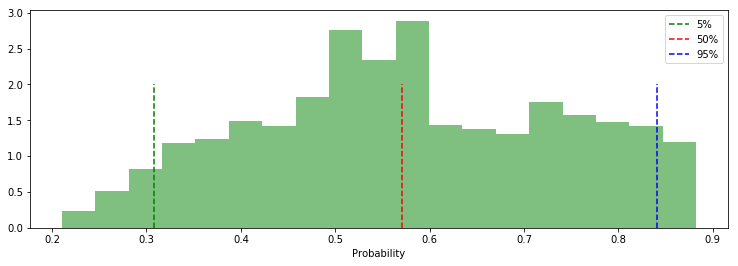

In [47]:
plt.figure(figsize=(12.5,4))
line_height = 2
data = averagingModels(X_train,best_models)
x = plt.hist(data, bins='auto', density=True, facecolor='green', alpha=0.5)

plt.vlines(np.percentile(data, 5), 0, line_height, linestyle="--", colors='green', label="5%")
plt.vlines(np.percentile(data, 50), 0, line_height, linestyle="--", colors='red', label="50%")
plt.vlines(np.percentile(data, 95), 0, line_height, linestyle="--", colors='blue', label="95%")
plt.xlabel('Probability')
plt.legend()

## Scoring

In [67]:
def scrape_round(rnd):
    table_num = rnd
    url = 'https://afltables.com/afl/seas/2019.html'
    r = requests.get(url, headers={'User-Agent': 'test'}, proxies=proxyDict)
    soup = BeautifulSoup(r.text, "html")
    table = soup.find_all('table')[table_num]
    data = []
    rows = table.find_all(['tr', 'th'])
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
    return [data[0][0],data[1][0]]
scrape_round(98)

['West Coast', 'Melbourne']

In [68]:
games = []
for i in range(98,107):
    games.append(scrape_round(i))
games

[['West Coast', 'Melbourne'],
 ['Collingwood', 'St Kilda'],
 ['Brisbane Lions', 'Adelaide'],
 ['Geelong', 'Western Bulldogs'],
 ['Essendon', 'Fremantle'],
 ['North Melbourne', 'Sydney'],
 ['Port Adelaide', 'Gold Coast'],
 ['Richmond', 'Hawthorn'],
 ['Greater Western Sydney', 'Carlton']]

In [79]:
scoring = []
for i in games:
    home = i[0]
    away = i[1]
    home_df = History(mapping,proxyDict).team_roll(home, season=0, shift=0, web=True).tail(1)[
        ['Rnd','F_mean','F_std','A_mean','A_std','M_mean','A_std','W_sum','perc']]
    home_df['Rnd'] = home_df['Rnd'] + 1
    away_df = History(mapping,proxyDict).team_roll(away, season=0, shift=0, web=True).tail(1)[
        ['F_mean','F_std','A_mean','A_std','M_mean','A_std','W_sum','perc']]
    features1 = np.concatenate([home_df.values[0],away_df.values[0]], axis=0)

    home_df2 = History(mapping,proxyDict).team_roll_ha(home, home_away='H', season=0, shift=0, web=True).tail(1)[
        ['F_mean','F_std','A_mean','A_std','M_mean','A_std','W_sum','perc']]
    away_df2 = History(mapping,proxyDict).team_roll_ha(home, home_away='A', season=0, shift=0, web=True).tail(1)[
        ['F_mean','F_std','A_mean','A_std','M_mean','A_std','W_sum','perc']]
    features2 = np.concatenate([home_df2.values[0],away_df2.values[0]], axis=0)
    scoring.append(np.concatenate([features1, features2], axis=0))

In [89]:
scoring_enr = feature_eng.Features().div_cols(scoring)
scoring_enr

array([[ 9.00000000e+00,  7.45000000e+01,  2.14209510e+01,
         7.65000000e+01,  2.13541565e+01, -2.00000000e+00,
         2.13541565e+01,  5.00000000e+00,  9.73856209e-01,
         6.95000000e+01,  2.53264402e+01,  9.18750000e+01,
         2.45731416e+01, -2.23750000e+01,  2.45731416e+01,
         3.00000000e+00,  7.56462585e-01,  7.65000000e+01,
         2.14242853e+01,  6.50000000e+01,  2.01163284e+01,
         1.15000000e+01,  2.01163284e+01,  3.00000000e+00,
         1.17692308e+00,  7.25000000e+01,  2.45153013e+01,
         8.80000000e+01,  1.75119007e+01, -1.55000000e+01,
         1.75119007e+01,  2.00000000e+00,  8.23863636e-01,
         1.07194245e+00,  1.05517241e+00,  8.45793996e-01,
         8.73914825e-01,  8.32653061e-01,  7.38636364e-01,
         8.69003927e-01,  1.14872330e+00,  8.93854749e-02,
        -7.41935484e-01,  8.69003927e-01,  1.14872330e+00,
         1.28738186e+00,  1.42854111e+00],
       [ 9.00000000e+00,  9.23750000e+01,  2.16394976e+01,
         7.32

In [88]:
arr = np.c_[ games, averagingModels(scoring_enr,best_models) ] 
pd.DataFrame(arr,columns=['home','away','prob_home_win'])

,home,away,prob_home_win
0,West Coast,Melbourne,0.58550465
1,Collingwood,St Kilda,0.5026461
2,Brisbane Lions,Adelaide,0.62475955
3,Geelong,Western Bulldogs,0.64188296
4,Essendon,Fremantle,0.5866833
5,North Melbourne,Sydney,0.5632977
6,Port Adelaide,Gold Coast,0.60889816
7,Richmond,Hawthorn,0.6213473
8,Greater Western Sydney,Carlton,0.5898107


In [ ]:
# pd.DataFrame(scoring_enr,columns=training_cols)

## Save models

In [49]:
from joblib import dump, load
# for i in range(len(best_models)):
#     dump(best_models[i], 'models/model'+str(i)+'.joblib') 

## Load models

In [87]:
best_models = []
for i in range(9):
    best_models.append(load('models/model'+str(i)+'.joblib'))